 
# <center> Analyze A/B Test Results </center>
    
    
<center><i>GHAIDA .S ALTUWAIJRI </i></center>
<center><i>jun 22, 2020</i></center> 




## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will work to understand the results of an A/B test run by an e-commerce website.My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [58]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [59]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [60]:
print (df.shape[0])

294478


c. The number of unique users in the dataset.

In [61]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [62]:
print(len(df[df['converted']==1])/df.shape[0]) # 12%

0.11965919355605512


e. The number of times the `new_page` and `treatment` don't match.

In [63]:
(len(df[(df['landing_page']=='new_page') & (df['group']!='treatment')]) +
 len(df[(df['landing_page']!='new_page') & (df['group']=='treatment')]))

3893

f. Do any of the rows have missing values?

In [64]:
# The Answer is 'No'
show_null = df.isnull().sum() 
show_null

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [65]:
# check if there is any missing values at all and get a total count of missing values
print(df.isnull().values.any())
print(df.isnull().sum().sum())

False
0


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [66]:
df2 = df[((df['group'] == 'treatment') != (df['landing_page'] == 'old_page'))]
df2.count()

user_id         290585
timestamp       290585
group           290585
landing_page    290585
converted       290585
dtype: int64

In [67]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [68]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [69]:
df2['user_id'][df2['user_id'].duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [70]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [71]:
df2['user_id'].drop_duplicates()

0         851104
1         804228
2         661590
3         853541
4         864975
           ...  
294473    751197
294474    945152
294475    734608
294476    697314
294477    715931
Name: user_id, Length: 290584, dtype: int64

In [72]:
pd.options.mode.chained_assignment = None  # default='warn'
df2.drop_duplicates(subset='user_id',inplace=True)

In [73]:
len(df2)

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [74]:
print(len(df2[df2['converted']==1])/df2.shape[0]) #0.1196

0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [75]:
# len(df2[(df2['group']=='control') & (df2['converted']==1)])/(len(df2[df2['group']=='control'])) #0.1204
df2[df2['group']=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [76]:
#len(df2[(df2['group']=='treatment') & (df2['converted']==1)])/(len(df2[df2['group']=='treatment'])) #0.1188
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [77]:
len(df2[df2['landing_page']=='new_page'])/df2.shape[0] #0.5001

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

<font color=darkblue> The probability of individual in the **new treatment page** and converted is **0.1188** 
which leads to less conversions than **0.1204** which is the individual in the **control** group and converted.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<font color=darkblue>
    
The null hypothesis is, that the old page has a higher or equal conversion rate than the new one:
    
$H_{0}$: $p_{new}$ ${\le}$ $p_{old}$ , 
    
    
    
In contrast, it may be proven that the new page has a higher conversion rate than the old page:
    
$H_{1}$: $p_{new}$ ${\gt}$ $p_{old}$
    

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [78]:
p_new=df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [79]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [80]:
n_new=len(df2[df2['landing_page']=='new_page'])
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [81]:
n_old=len(df2[df2['landing_page']=='old_page'])
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [82]:
new_page_converted =np.random.binomial(n=1,p=p_new,size=n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [83]:
old_page_converted =np.random.binomial(n=1,p=p_old,size=n_old)
old_page_converted

array([0, 0, 0, ..., 1, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [84]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.0013579041775914763

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [136]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

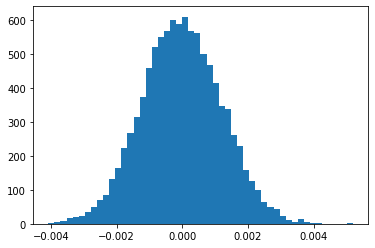

In [137]:
plt.hist(p_diffs, bins=50);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [87]:
new_conv=df2[df2['group']=='treatment']['converted'].mean()
old_conv=df2[df2['group']=='control']['converted'].mean()
act_diff=new_conv-old_conv
# act_diff
p_diffs=np.array(p_diffs)
# p_diffs
(p_diffs > act_diff).mean()

0.9088

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<font color=darkblue> 
The value calculated is the p-value, the large p value indicates that conversion rate for the old page is better than or equal to the new page, So we  failed to reject the null hypothesis.
    
Therefore, we would **not recommend to move to the new page**.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [88]:
import statsmodels.api as sm

convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]

print(' convert_old:', convert_old ,'\n','convert_new:', convert_new , '\n', 'n_old:', n_old ,'\n','n_new:', n_new )

 convert_old: 17489 
 convert_new: 17264 
 n_old: 145274 
 n_new: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [89]:
# stats.proportions_ztest

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(' z_score:',z_score, '\n' ,'p_value:', p_value)

 z_score: 1.3109241984234394 
 p_value: 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<font color=darkblue> 
  The calculated p-value agrees with the finding in part j, And the z-score indicates how many standard deviations it is far away from the mean. So, the conversion rate for the old page is better than or equal to the new page, and we failed again to reject the null hypothesis and **not recommend to move to the new page**.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<font color=darkblue>  **The Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [90]:
#Create intercept column
df2['intercept'] = 1

In [91]:
#Create dummies
ab_page = ['treatment', 'control']
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']

In [92]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [93]:
import statsmodels.api as sm

predictors=['intercept','ab_page']
logit_mod=sm.Logit(df2['converted'],df2[predictors])
results=logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [94]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:30:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

<font color=darkblue>
    
The Part II was one sided test and the last one is two sided with 0.190 p-value which is different from the value found in PartII (0.9).
    
Here we test the null hypothesis where the old page has an equal conversion rate with the new one. 
  
$H_{0}: p_{new}=p_{old}$

    
In contrast, it may be proven that the new page has not equal conversion with the old page:   
    
$H_{1}: p_{new}\ne p_{old}$
    
the large 0.190 p-value also indicates that conversion rate for the old page is better than or equal to the new page, So we failed to reject the null hypothesis. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<font color=darkblue>

Users from different countries , genders, and ages may have different favourite designs. Adding some information about users could reveal the hidden value of the new page for specific categories the users.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [95]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [106]:
### Create the necessary dummy variables
df_new['intercept'] = 1
df_new[['CA','US']] = pd.get_dummies(df_new['country'])[['CA','US']]
df_new

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0,0,1
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0,0,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0,0,0


In [119]:
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'CA', 'ab_page']])
results = mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 22 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        14:42:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

<font color=darkblue>

The p-value is **higher in US than in Canada**, which means that users in the US are more likely to convert,suggest that **they are not statistically significant**.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [118]:
## Fit Your Linear Model And Obtain the Results
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
mod = sm.Logit(df_new['converted'], df_new[['intercept']])
results = mod.fit()
df_new.head()

Optimization terminated successfully.
         Current function value: 0.366121
         Iterations 6


,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US,US_ab_page,CA_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,0,0


In [117]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            0
Date:                Mon, 22 Jun 2020   Pseudo R-squ.:               1.974e-13
Time:                        14:41:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -349.182      0.000      -2.007      -1.985
==============================================================================
"""

<font color=darkblue>

The p-value for US and CA are large indicating that they are not statistically significant so they are **not enough evidence to reject the null hypothesis**

<a id='conclusions'></a>
## Conclusions

<font color=darkblue>


The A/B testing, Logistic Regression, and also the country's non-impact on conversion rate and interaction leads to the same result. We accepted the Null Hypothesis and Rejected the Alternate Hypothesis. So it's seems that there is no benefits for the company to change to the new site.
These inferences are strictly based on the available data . This analysis acknowledges its limitations due to factors not included in the data.

## References

   <font color=darkblue>
 
 - Project Walkthrough
 
 - Udacity Course content 